In [8]:
# === STEP 3 & 4: Load Data & Select GHI ===
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings('ignore')

# 1. Setup Path (Adjust this path if your Drive structure is different)
# Assuming you are using Google Colab:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/ASM_project/Rajasthan1'

# 2. Load and Merge Files
all_files = glob.glob(os.path.join(folder_path, "*.csv"))
df_list = []

for filename in all_files:
    # Assumption: The actual headers are on row 3 (index 2), skipping metadata rows
    df_temp = pd.read_csv(filename, header=2)
    df_list.append(df_temp)

data = pd.concat(df_list, axis=0, ignore_index=True)

# 3. Create Datetime Index
# Combining Year, Month, Day, Hour, Minute into a single datetime column
data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour', 'Minute']])
data.set_index('Datetime', inplace=True)
data.sort_index(inplace=True)

# 4. Focus on GHI
# The problem asks to analyze GHI specifically
ghi_data = data[['GHI', 'Temperature', 'Relative Humidity', 'DNI']] # Keeping others for correlation
print("Data Loaded. Shape:", ghi_data.shape)
print(ghi_data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data Loaded. Shape: (131400, 4)
                     GHI  Temperature  Relative Humidity  DNI
Datetime                                                     
2000-01-01 00:00:00    0    13.811437          27.447862    0
2000-01-01 01:00:00    0    13.117300          29.048857    0
2000-01-01 02:00:00    0    12.433960          31.216659    0
2000-01-01 03:00:00    0    11.797632          34.956075    0
2000-01-01 04:00:00    0    11.195487          41.177540    0



Descriptive Statistics:
                 GHI    Temperature  Relative Humidity            DNI
count  131400.000000  131400.000000      131400.000000  131400.000000
mean      237.890068      28.197716          34.840594     207.312869
std       315.345071       8.433940          23.262578     275.825066
min         0.000000       4.366332           0.355050       0.000000
25%         0.000000      22.629722          16.397738       0.000000
50%         0.000000      28.722314          27.583978       0.000000
75%       501.000000      33.871842          49.744047     490.000000
max       995.000000      51.817446         100.000000     838.000000


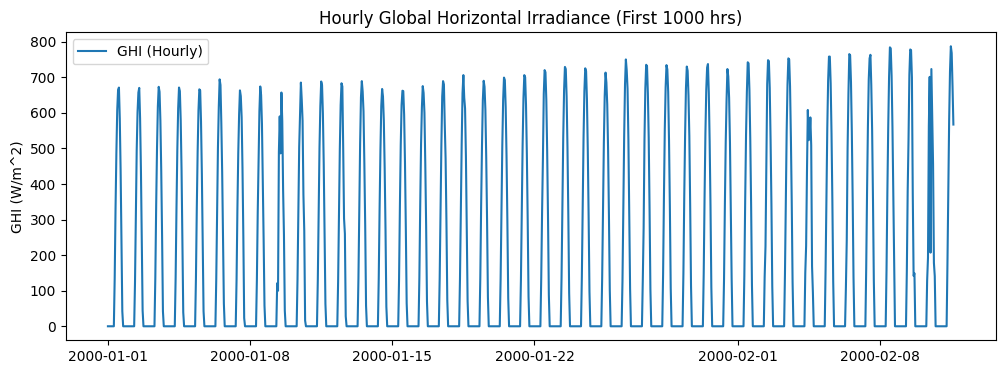

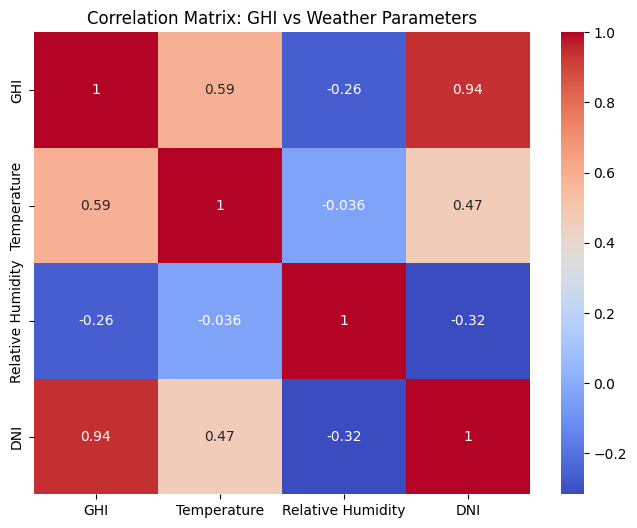

In [9]:
# === STEP 5: Descriptive Statistics & Graphical Plots ===

# Descriptive Stats
print("\nDescriptive Statistics:")
print(ghi_data.describe())

# Visualization 1: GHI over time (First 1000 hours to see daily pattern)
plt.figure(figsize=(12, 4))
plt.plot(ghi_data['GHI'].iloc[:1000], label='GHI (Hourly)')
plt.title('Hourly Global Horizontal Irradiance (First 1000 hrs)')
plt.ylabel('GHI (W/m^2)')
plt.legend()
plt.show()

# Visualization 2: Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(ghi_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: GHI vs Weather Parameters')
plt.show()

Datetime
2000-01-01 08:00:00    135
2000-01-01 09:00:00    331
2000-01-01 10:00:00    488
2000-01-01 11:00:00    608
2000-01-01 12:00:00    664
Name: GHI, dtype: int64


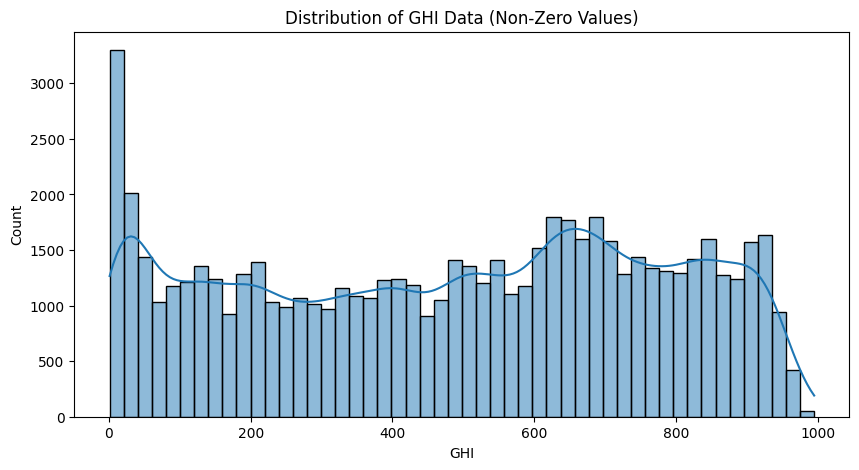


Normality Test (K-S Test): P-value = 0.0
Result: The data does NOT follow a normal distribution.
Observation: Solar data is often bimodal (Day vs Night) or Beta distributed.


In [10]:
# === STEP 6: Probability Distribution Analysis ===

# CREATE A COPY OF GHI AND DROP THE VALUES WHERE GHI IS ZERO
# Convert GHI column to numeric
ghi_data['GHI'] = pd.to_numeric(ghi_data['GHI'], errors='coerce')

# CREATE A COPY OF GHI AND DROP THE VALUES WHERE GHI IS ZERO
ghi_non_zero = ghi_data.loc[ghi_data['GHI'] > 0, 'GHI'].copy()

print(ghi_non_zero.head(5))

# 1. Histogram and KDE
plt.figure(figsize=(10, 5))
sns.histplot(ghi_non_zero, kde=True, bins=50)
plt.title('Distribution of GHI Data (Non-Zero Values)')
plt.show()

# 2. Normality Test
# Using Kolmogorov-Smirnov test because sample size is large (>5000)
# (Shapiro-Wilk is too sensitive for large N)
k_stat, p_value = stats.kstest(ghi_non_zero, 'norm')
print(f"\nNormality Test (K-S Test): P-value = {p_value}")

if p_value < 0.05:
    print("Result: The data does NOT follow a normal distribution.")
    print("Observation: Solar data is often bimodal (Day vs Night) or Beta distributed.")
else:
    print("Result: The data looks Normal.")

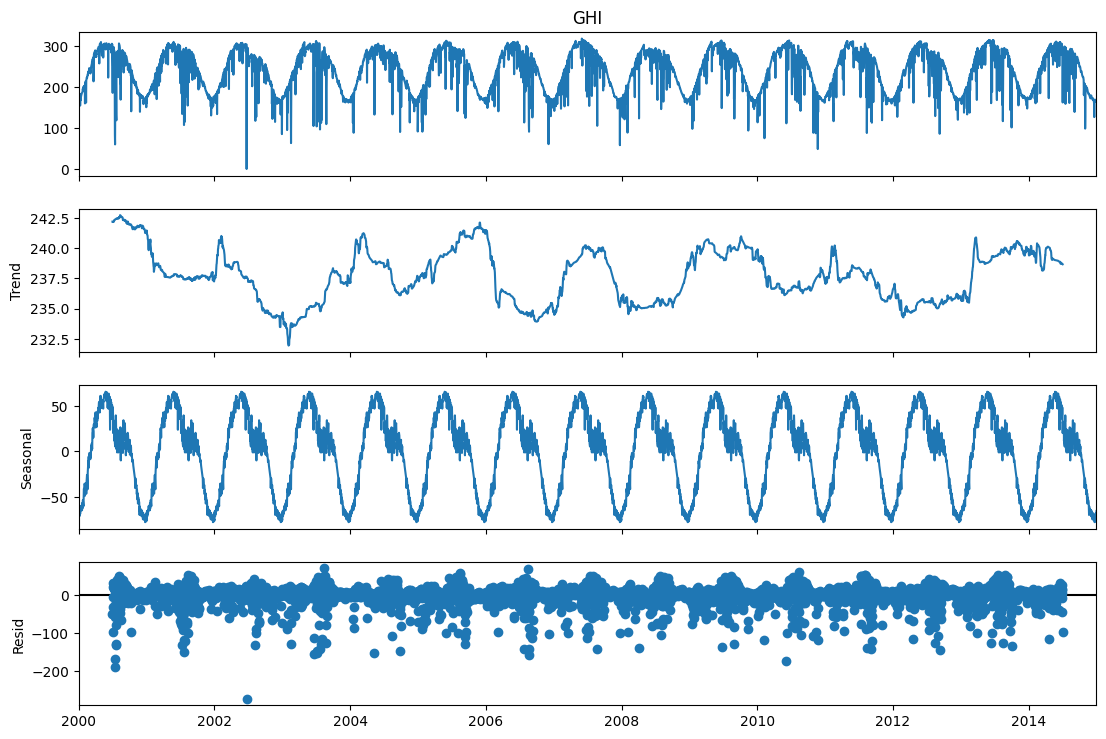


ADF Statistic: -5.41457996190709
p-value: 3.156373328680452e-06
Result: Data is Stationary (Ready for ARIMA)
                               SARIMAX Results                                
Dep. Variable:                    GHI   No. Observations:                 5114
Model:                 ARIMA(5, 0, 1)   Log Likelihood              -23473.745
Date:                Fri, 21 Nov 2025   AIC                          46963.490
Time:                        15:52:32   BIC                          47015.808
Sample:                    01-01-2000   HQIC                         46981.806
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        237.8225     13.419     17.722      0.000     211.521     264.124
ar.L1          1.2509

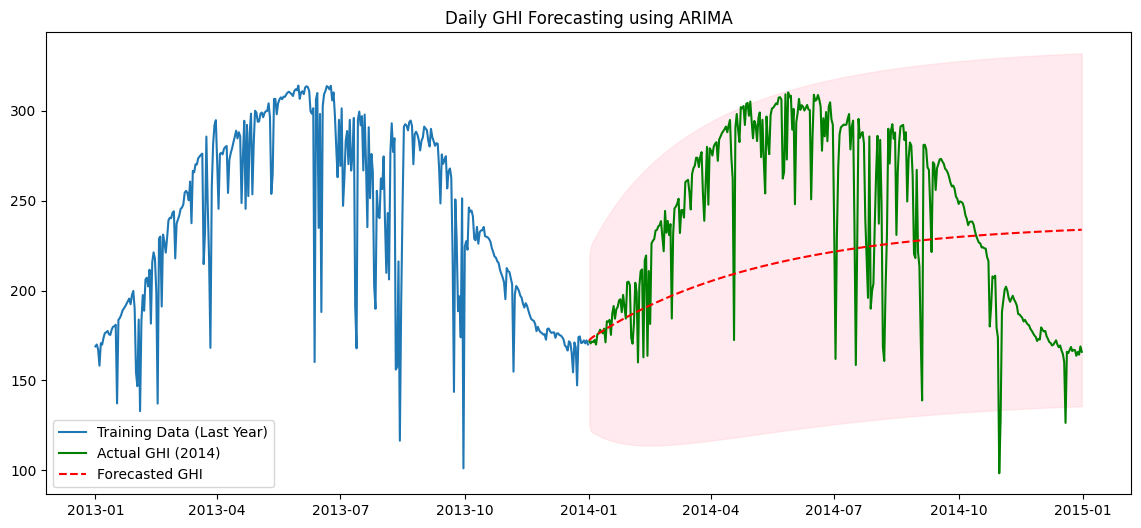


Validation RMSE: 55.90


In [11]:
# === STEP 7: Time Series Analysis (Trend, Seasonality, ARIMA) ===

# 1. Resample to Daily Mean GHI
# Hourly data is too noisy and large for standard ARIMA
daily_ghi = ghi_data['GHI'].resample('D').mean()

# Fill any small missing gaps if they exist
daily_ghi = daily_ghi.interpolate()

# 2. Decomposition (Trend, Seasonality, Residual)
decomposition = seasonal_decompose(daily_ghi, model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# 3. Stationarity Test (Augmented Dickey-Fuller)
result = adfuller(daily_ghi)
print(f"\nADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print("Result: Data is Stationary (Ready for ARIMA)")
    d_param = 0
else:
    print("Result: Data is Non-Stationary (Needs Differencing)")
    d_param = 1

# 4. ARIMA Forecasting
# Split Data (Train on 2000-2013, Test on 2014)
train = daily_ghi[daily_ghi.index.year < 2014]
test = daily_ghi[daily_ghi.index.year == 2014]

# Fit ARIMA Model
# Note: (p,d,q) usually requires tuning using ACF/PACF plots.
# Here we use a standard configuration for demonstration.
# Ideally, use auto_arima from 'pmdarima' library if available.
p, d, q = 5, d_param, 1
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

# Forecast
forecast_result = model_fit.get_forecast(steps=len(test))
forecast_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# === STEP 8: Validation ===

# Plotting Forecast vs Actual
plt.figure(figsize=(14, 6))
plt.plot(train.index[-365:], train[-365:], label='Training Data (Last Year)')
plt.plot(test.index, test, label='Actual GHI (2014)', color='green')
plt.plot(test.index, forecast_values, label='Forecasted GHI', color='red', linestyle='--')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Daily GHI Forecasting using ARIMA')
plt.legend()
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, forecast_values))
print(f"\nValidation RMSE: {rmse:.2f}")

In [12]:
# === OPTIONAL: Machine Learning Approach ===
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare features (Lag features + Weather variables)
df_ml = ghi_data.resample('D').mean().interpolate()
df_ml['GHI_Lag1'] = df_ml['GHI'].shift(1) # Yesterday's GHI
df_ml.dropna(inplace=True)

X = df_ml[['GHI_Lag1', 'Temperature', 'Relative Humidity']]
y = df_ml['GHI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)

print(f"Random Forest RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}")

Random Forest RMSE: 23.77


Training SARIMAX model (this may take a moment)...


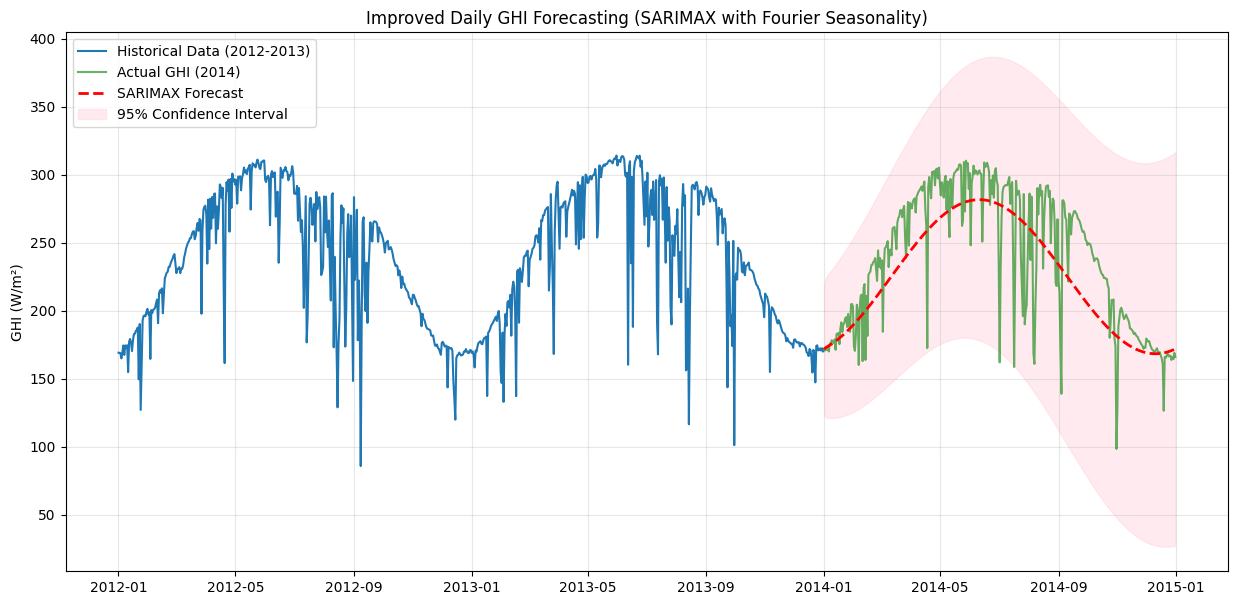

Model Summary:
RMSE: 30.77


In [13]:
# === STEP 7 & 8 (REVISED): SARIMAX with Fourier Seasonality ===
# This block runs independently assuming 'ghi_data' is already loaded.

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Prepare Daily Data (Aggregation)
# We work with daily means to reduce noise
df_forecast = ghi_data[['GHI']].resample('D').mean().interpolate()

# 2. Feature Engineering: Fourier Terms (The "Curve" Fix)
# Standard ARIMA struggles to "remember" 365 days ago.
# We create Sine/Cosine features to explicitly model the annual cycle.
df_forecast['day_of_year'] = df_forecast.index.dayofyear
# Creates a wave that repeats every 365 days
df_forecast['sin_365'] = np.sin(2 * np.pi * df_forecast['day_of_year'] / 365)
df_forecast['cos_365'] = np.cos(2 * np.pi * df_forecast['day_of_year'] / 365)

# These are our "Exogenous" (external) variables
exog_data = df_forecast[['sin_365', 'cos_365']]

# 3. Split Data (Train: 2000-2013, Test: 2014)
train_end_year = 2013
train_mask = df_forecast.index.year <= train_end_year
test_mask = df_forecast.index.year == 2014

y_train = df_forecast.loc[train_mask, 'GHI']
y_test = df_forecast.loc[test_mask, 'GHI']

exog_train = exog_data.loc[train_mask]
exog_test = exog_data.loc[test_mask]

# 4. Fit SARIMAX Model
# Order=(p,d,q): (1,1,1) is a standard starting point for daily trends
# Exog: Feeds the sine wave into the model so it knows the season
print("Training SARIMAX model (this may take a moment)...")
model = SARIMAX(y_train,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0,0,0,0), # Seasonality is handled by exog
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# 5. Forecast
# We must provide the future sine/cosine values (exog_test) for the forecast
forecast_result = model_fit.get_forecast(steps=len(y_test), exog=exog_test)
pred_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 6. Visualization
plt.figure(figsize=(15, 7))

# Plot last 2 years of training to show continuity
plot_start_date = '2012-01-01'
train_subset = y_train[y_train.index >= plot_start_date]

plt.plot(train_subset.index, train_subset, label='Historical Data (2012-2013)')
plt.plot(y_test.index, y_test, label='Actual GHI (2014)', color='green', alpha=0.6)
plt.plot(y_test.index, pred_mean, label='SARIMAX Forecast', color='red', linestyle='--', linewidth=2)

# Confidence Intervals
plt.fill_between(y_test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Improved Daily GHI Forecasting (SARIMAX with Fourier Seasonality)')
plt.ylabel('GHI (W/m²)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# 7. Validation Metrics
rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
print(f"Model Summary:\nRMSE: {rmse:.2f}")